<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_h5py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py

In [2]:
"""
New Python Based Pipeline for Trodes
"""

'\nNew Python Based Pipeline for Trodes\n'

In [3]:
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Finde APs """
""" Find IIS """


' Find IIS '

In [13]:
import os
import tempfile
import h5py
import subprocess
import numpy as np
# trodes_dat_reader_loc = 'C:/Users/dennis.tabuena/Desktop/_SPIKE_GADGETS/Trodes_2-5-1_Windows64/Trodes_2-5-1_Windows64/Resources/TrodesToPython'
trodes_dat_reader_loc = 'C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\LFP_Refactor\\Trodes_2-5-1_Windows64\\Resources\\TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
from tqdm import tqdm

def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    print(f'Loading {dtype} array shape:{shape}...')
    with open(npy_filename, 'rb') as f:
        array = np.memmap(f, dtype=dtype, mode='r+', offset=offset, shape=shape)
    print('     complete.')
    return array

def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()

def plot_sample_wave(lfp,sample_rate,times=[0,3],ref=None):
    colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
    tic_indicies = np.arange(times[0]*sample_rate,times[1]*sample_rate)
    time_sec = tic_indicies/sample_rate
    waveform = lfp[tic_indicies,:]
    # waveform = waveform - np.expand_dims(np.mean(waveform,axis=1),axis=-1)
    # waveform = waveform - np.expand_dims(waveform[:,24],axis=-1)

    num_chan = waveform.shape[1]
    if ref is not None:
        num_chan+= 1
    fig,ax=plt.subplots(num_chan,1,figsize=(6,2),dpi=300)
    for ch in np.arange(num_chan):
        if ch>=waveform.shape[1]:
            print(ch)
            ax[ch].plot(time_sec,-ref[tic_indicies],linewidth=.2,color='c')
        else:
            ax[ch].plot(time_sec,waveform[:,ch],linewidth=.2,color=colors[ch])
        ax[ch].set_position([0,ch/num_chan,1,1/num_chan])
        ax[ch].axis('off')

    return



In [83]:
def update_hdf_data(file_path, dataset_name, new_data,dtype=None):
    """
    Update an existing dataset in an HDF5 file or create a new one if it doesn't exist.

    Parameters:
    - file_path (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset to update or create.
    - new_data (numpy.ndarray): Data to write into the dataset.
    """

    # Open an HDF5 file in read/write mode
    with h5py.File(file_path, 'a') as hdf_file:
        # Check if dataset already exists
        if dataset_name in hdf_file:
            # Dataset exists, update its contents
            del hdf_file[dataset_name]
            hdf_file[dataset_name] = new_data
            print(f"Dataset '{dataset_name}' updated.")
        else:
            # Dataset does not exist, create a new one
            if dtype is None:
                dtype = new_data.dtype
            hdf_file.create_dataset(dataset_name, data=new_data, dtype=dtype)
            print(f"Dataset '{dataset_name}' created with new data.")

        hdf_file.close()

In [96]:
def list_hdf5_dataset_names(file_path):
    """
    List all dataset names in an HDF5 file.

    Parameters:
    - file_path (str): Path to the HDF5 file.
    """
    with h5py.File(file_path, 'r') as hdf_file:
        def print_dataset_name(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(name)
                print(obj.dtype)

        hdf_file.visititems(print_dataset_name)


In [62]:
import h5py
import numpy as np
import os
import tempfile

def load_hdf5_to_memmap(hdf5_filename, dataset_name):
    """
    Load a dataset from an HDF5 file into a NumPy memmap array.

    Parameters:
    - hdf5_filename (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset within the HDF5 file.

    Returns:
    - memmap_array (numpy.memmap): Memmap array containing the dataset.
    """

    with h5py.File(hdf5_filename, 'r') as f:
        # Read metadata from HDF5 attributes or dataset properties
        dataset = f[dataset_name]
        shape = dataset.shape
        dtype = dataset.dtype

        print(f'Loading {dtype} array shape: {shape} from HDF5...')

        if shape == ():  # Check if the dataset is scalar
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()

            # Create memmap array for a single scalar value
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=(1,))
            memmap_array[0] = float(dataset[()])
        else:
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()

            # Create memmap array and write data to it
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=shape)
            memmap_array[:] = dataset[:]
        f.close()
    print('Loading complete.')

    return memmap_array

In [5]:
""" PLOT CONFIG """
### quick import
import urllib
import json
import matplotlib as mpl
from matplotlib import rcParams
def import_mpl_config(FS=6):
    """ Load my default plotting parameters """
    if os.path.isfile(f'./mpl_config_FS{FS}.json'):
        os.remove(f'./mpl_config_FS{FS}.json')
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/'\
                                   'raw//main/Matplotlib_Config/'\
                                   f'mpl_config_FS{FS}.json',
                                   f'mpl_config_FS{FS}.json')
    with open(f"./mpl_config_FS{FS}.json",'r') as import_file:
        fig_config = json.load(import_file)
    rcParams.update(fig_config)
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/raw/main/Fonts/arial.ttf','arial.ttf')
    mpl.font_manager.fontManager.addfont('./arial.ttf')
    return fig_config
_ = import_mpl_config()

In [6]:
""" Generate RAW_LFP Binaries from *.rec files"""
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\Test_Emily\AngelfoodCake01\AngelfoodCake01.rec'
full_cmd_raw = ' '.join([export_func_location, '-raw',
                    '-rec ', dot_rec_file_loc,
                    '-userawrefs', str(0),
                    '-outputdirectory', dest_dir])
# export_report = subprocess.run(full_cmd_raw)



In [11]:
my_analysis_dir = 'C:\\Users\\dennis.tabuena\\Desktop\\ReAnalyze'
os.chdir(my_analysis_dir)


""" Import RAW_LFP """
dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA\AngelfoodCake01.raw\AngelfoodCake01.raw_group0.dat'
animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')
dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])
default_sample_rate = dot_dat_data['clockrate']
num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]
memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
lfp_disk_array = dot_dat_data['data']['voltage'].astype('float16')
lfp_disk_array*=voltage_scaling

session_hdf_file=os.path.join(my_analysis_dir,animal_session+'.hdf5')
update_hdf_data(session_hdf_file, 'raw_lfp', lfp_disk_array)
update_hdf_data(session_hdf_file, 'default_sample_rate', default_sample_rate)



Loading float64 array shape: () from HDF5...
Loading complete.
Dataset 'downsampled_rate' updated.
Dataset 'ref_trace' created with new data.
Dataset 'downsampled_lfp' created with new data.
32


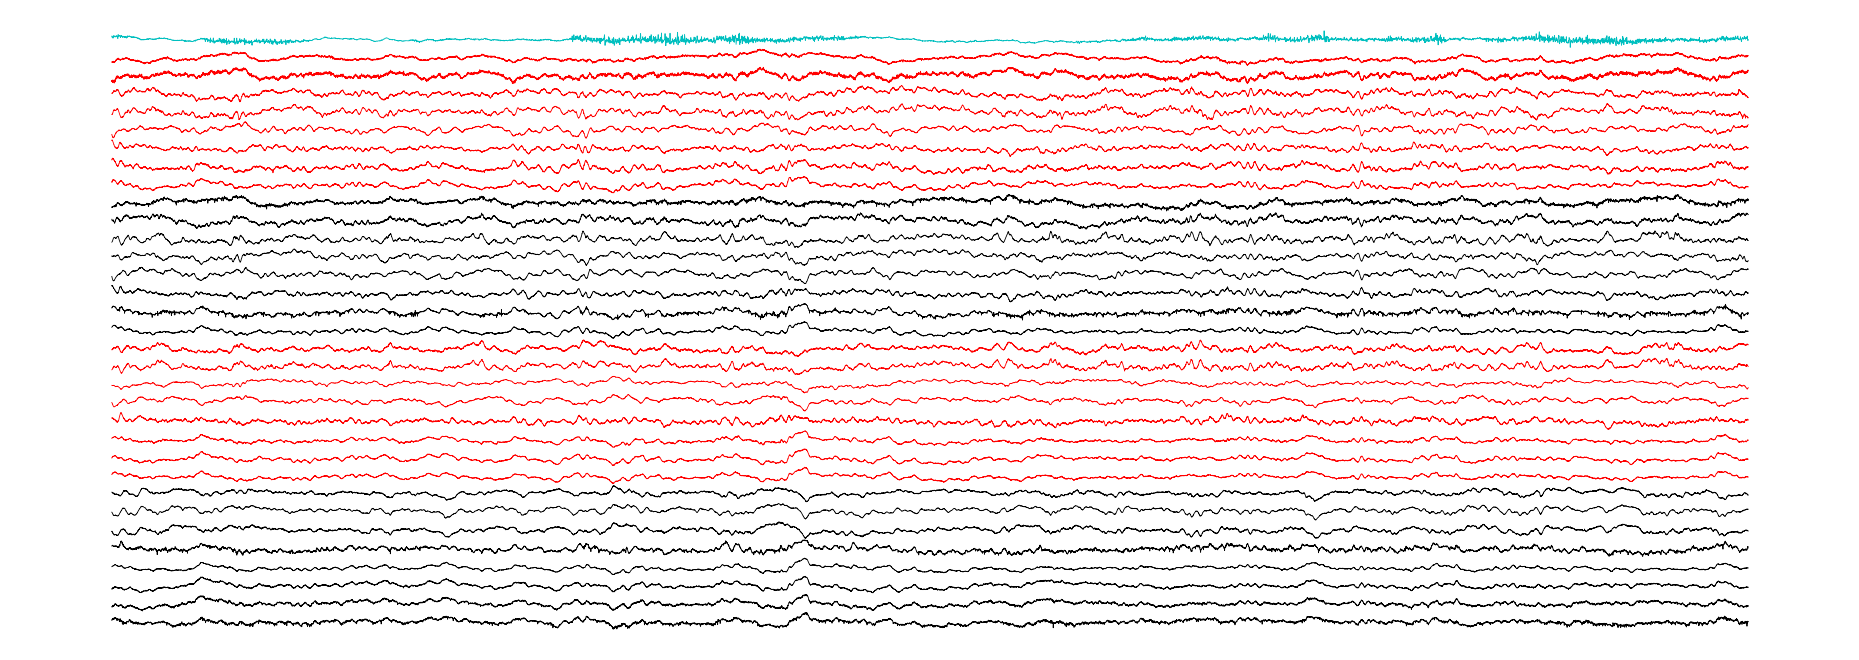

In [88]:
"""
DOWNSAMPLE & SAVE
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'raw_lfp')
default_sample_rate = load_hdf5_to_memmap(session_hdf_file, 'default_sample_rate')
downsampled_rate = 5000
update_hdf_data(session_hdf_file, 'downsampled_rate', downsampled_rate)

downsample_factor = default_sample_rate/downsampled_rate
downsample_indicies = np.arange(0,lfp_disk_array.shape[0],downsample_factor,dtype='int')
lfp_disk_array=lfp_disk_array[downsample_indicies,:]
ref = np.expand_dims(np.mean(lfp_disk_array,axis=1),axis=-1)
lfp_disk_array -= ref

update_hdf_data(session_hdf_file, 'ref_trace', ref)
update_hdf_data(session_hdf_file, 'downsampled_lfp', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate,ref=ref)


In [91]:
list_hdf5_dataset_names(session_hdf_file)

default_sample_rate
downsampled_lfp
downsampled_rate
raw_lfp
ref_trace


Loading float16 array shape: (21922734, 32) from HDF5...
Loading complete.
Dataset 'fir_coeff' updated.
Dataset 'passband' created with new data.
Dataset 'ripple_filtered' created with new data.


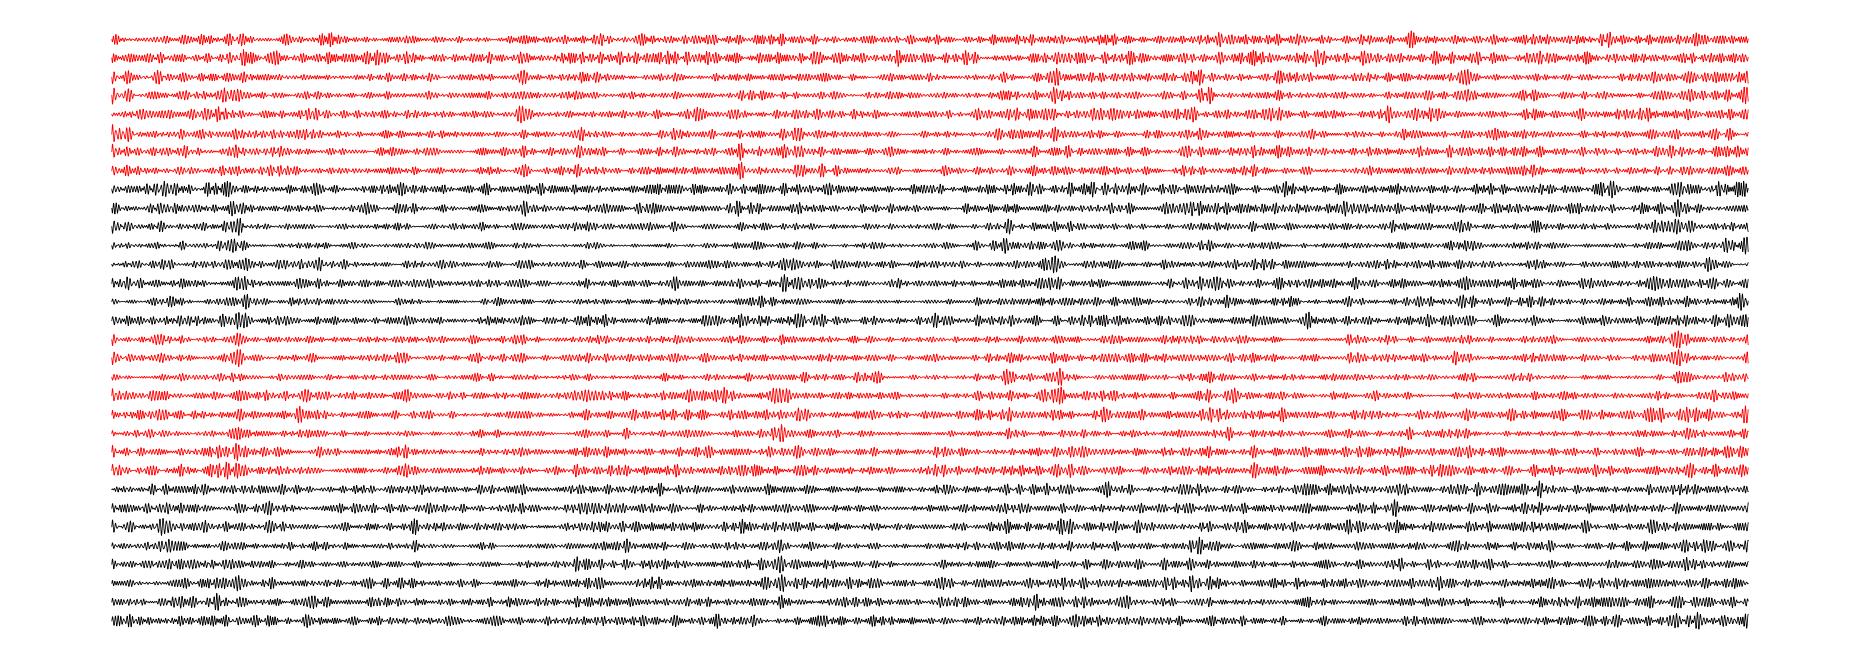

In [93]:
"""
BAND PASS FOR RIPPLES
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'downsampled_lfp')
passband = np.array([150, 250]) #(150-250 Hz)
num_coefficients = 1200
fir_coeff = sci.signal.firwin(num_coefficients, passband, width=10, window='hamming', pass_zero='bandpass', scale=True, fs=downsampled_rate)
update_hdf_data(session_hdf_file, 'fir_coeff', fir_coeff)
update_hdf_data(session_hdf_file, 'passband', passband)


''' Apply the FIR filter using filtfilt for zero-phase filtering across all channels '''
lfp_disk_array = sci.signal.filtfilt(fir_coeff, 1.0, lfp_disk_array, axis=0)
update_hdf_data(session_hdf_file, 'ripple_filtered', lfp_disk_array)

plot_sample_wave(lfp_disk_array,downsampled_rate)

In [97]:
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'ripple_filtered')
x0 = lfp_disk_array[:,13]
lfp_disk_array = load_hdf5_to_memmap(hilb_npy_filename)
x1 = lfp_disk_array[:,13]
x2 = np.abs(sci.signal.hilbert(x0,axis=0))
d = 1500
fig,ax=plt.subplots(figsize=(8,1))
ax.plot(x0[:d],color='k',linewidth=.2)
ax.plot(x1[:d]+50,color='c',linewidth=.2)
ax.plot(x2[:d]+100,color='m',linewidth=.2)


Loading float64 array shape: (21922734, 32) from HDF5...


KeyboardInterrupt: 

Loading float64 array shape: (21922734, 32) from HDF5...
Loading complete.
Dataset 'hilbert_enveelope' created with new data.


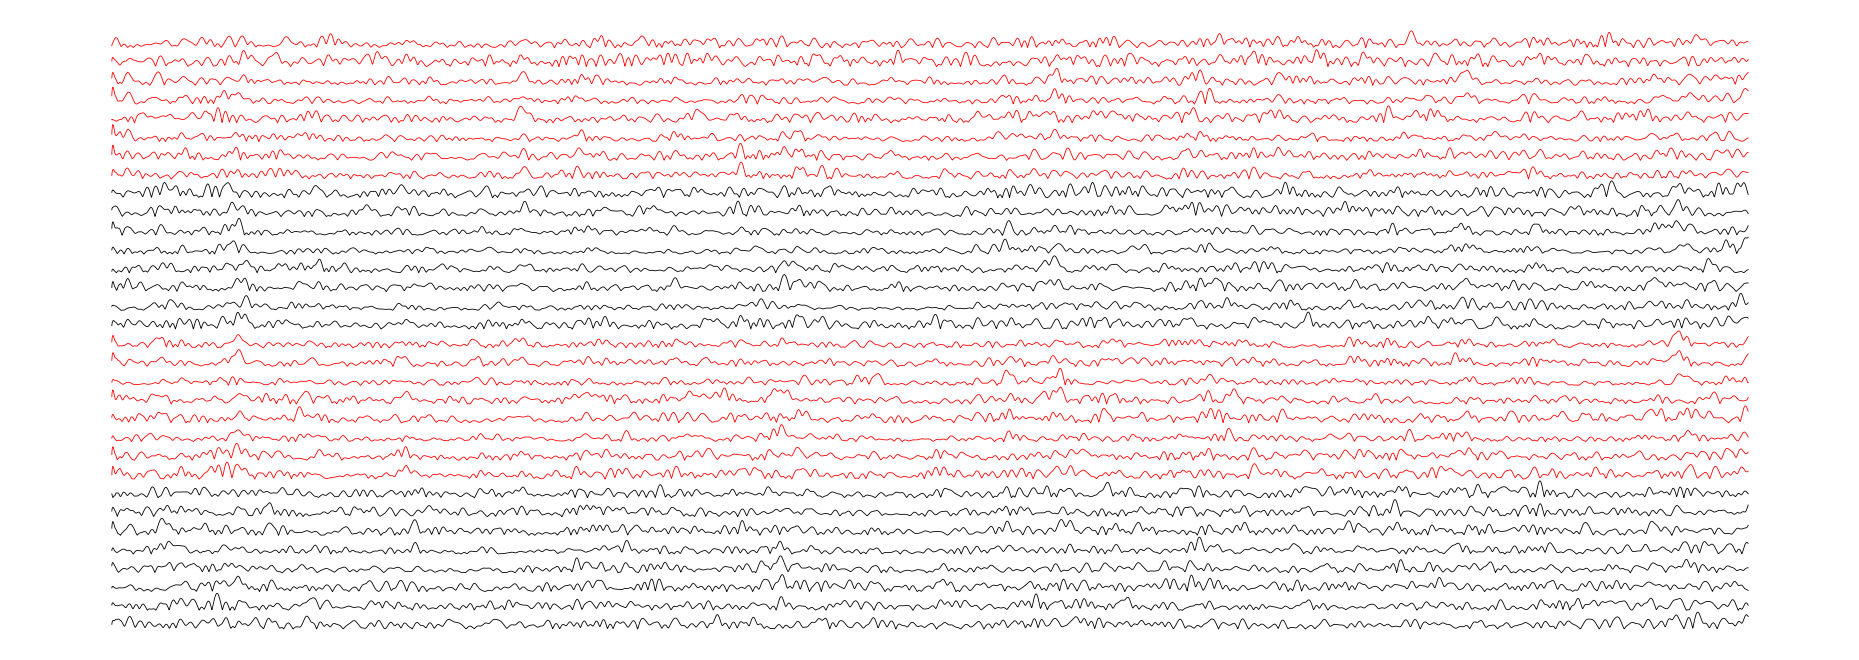

In [95]:
"""
Hilbert Envelope
"""
lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'ripple_filtered')
lfp_disk_array = abs(sci.signal.hilbert(lfp_disk_array,axis=0))
update_hdf_data(session_hdf_file, 'hilbert_enveelope', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

Loading float32 array shape:(21922734, 32)...
     complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:37<00:00,  4.92s/it]


AngelfoodCake01_rip_envl_lfp.npy AngelfoodCake01_hilbert_lfp.npy


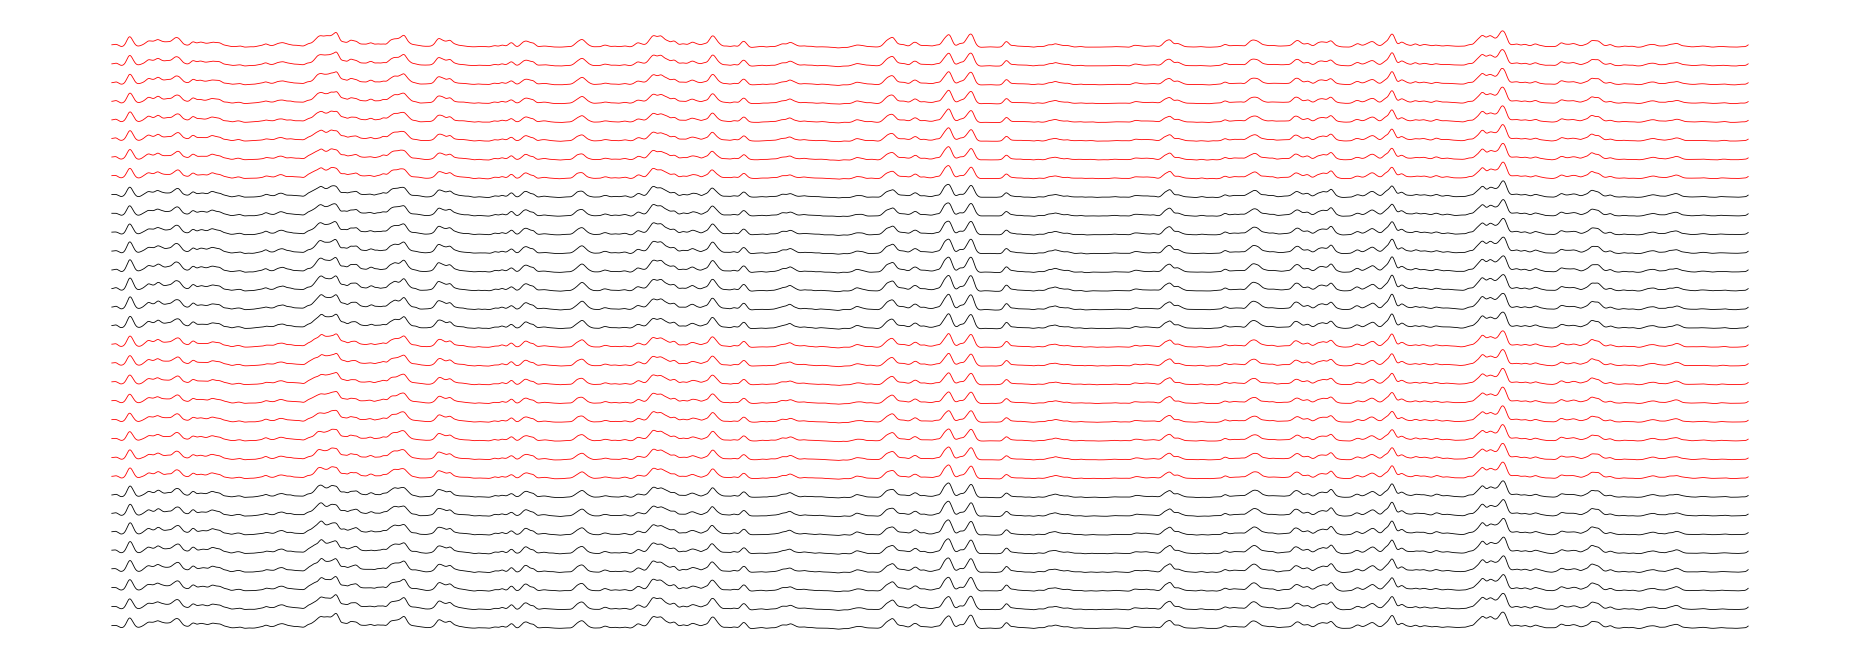

In [ ]:
"""
Smoothed
"""
lfp_disk_array = load_npy_to_memmap(hilb_npy_filename)
lfp_disk_array =  lfp_disk_array.astype('float32')
gauss_width_ms = 4
sigma = gauss_width_ms/1000*downsampled_rate
filter_width_sigmas = 8
num_channels = lfp_disk_array.shape[1]
for c in tqdm(np.arange(num_channels)):
    lfp_disk_array[:,c] = sci.ndimage.gaussian_filter1d(lfp_disk_array[:,c],
                                                sigma, axis=0, mode='reflect',
                                                truncate=filter_width_sigmas)
    lfp_disk_array[:,c] = (lfp_disk_array[:,c] - np.mean(lfp_disk_array[:,c]))/np.std(lfp_disk_array[:,c])
lfp_disk_array =  lfp_disk_array.astype('float16')

rip_envl_npy_filename = hilb_npy_filename.replace('hilbert', 'rip_envl')
np.save(rip_envl_npy_filename, lfp_disk_array.astype('float16'))
plot_sample_wave(lfp_disk_array,downsampled_rate)

print(rip_envl_npy_filename,hilb_npy_filename)

In [ ]:
os.listdir()

In [ ]:
def find_trace_ripples_df(trace, downsampled_rate, min_thresh_SD=3, min_dur=15, min_gap_ms=4):
    thresh_crossing = np.diff(trace > min_thresh_SD,prepend=0)
    starts = np.where(thresh_crossing==1)[0]
    stops = np.where(thresh_crossing==-1)[0]

    if trace[-1] > min_thresh_SD:
        '''drop last ripple if it didnt end'''
        starts=starts[:-1]

    min_gap_tics = int(min_gap_ms/1000*downsampled_rate)
    gap_dur = starts[1:]-stops[:-1]


    gaps_to_keep = gap_dur>min_gap_tics
    starts = starts[ np.insert(gaps_to_keep, 0, True) ]
    stops = stops[ np.insert(gaps_to_keep, -1, True) ]

    ripple_sd_max = np.zeros_like(starts).astype('float')
    max_tic = np.zeros_like(starts)
    for rip,(tic_on,tic_off) in enumerate(zip(starts,stops)):
        max_tic[rip] = np.argmax(trace[tic_on:tic_off])
        ripple_sd_max[rip] = trace[tic_on:tic_off][max_tic[rip]]

    channel_ripples_df = pd.DataFrame({'starts':starts,
                              'stops':stops,
                              'max_tic':max_tic,
                              'ripple_sd_max':ripple_sd_max})
    return channel_ripples_df



lfp_disk_array = load_npy_to_memmap(rip_envl_npy_filename)
ripples_df_list = [find_trace_ripples_df(lfp_disk_array[:,ch],downsampled_rate) for ch in np.arange(lfp_disk_array.shape[1])]

Loading float16 array shape:(21922734, 32)...
     complete.


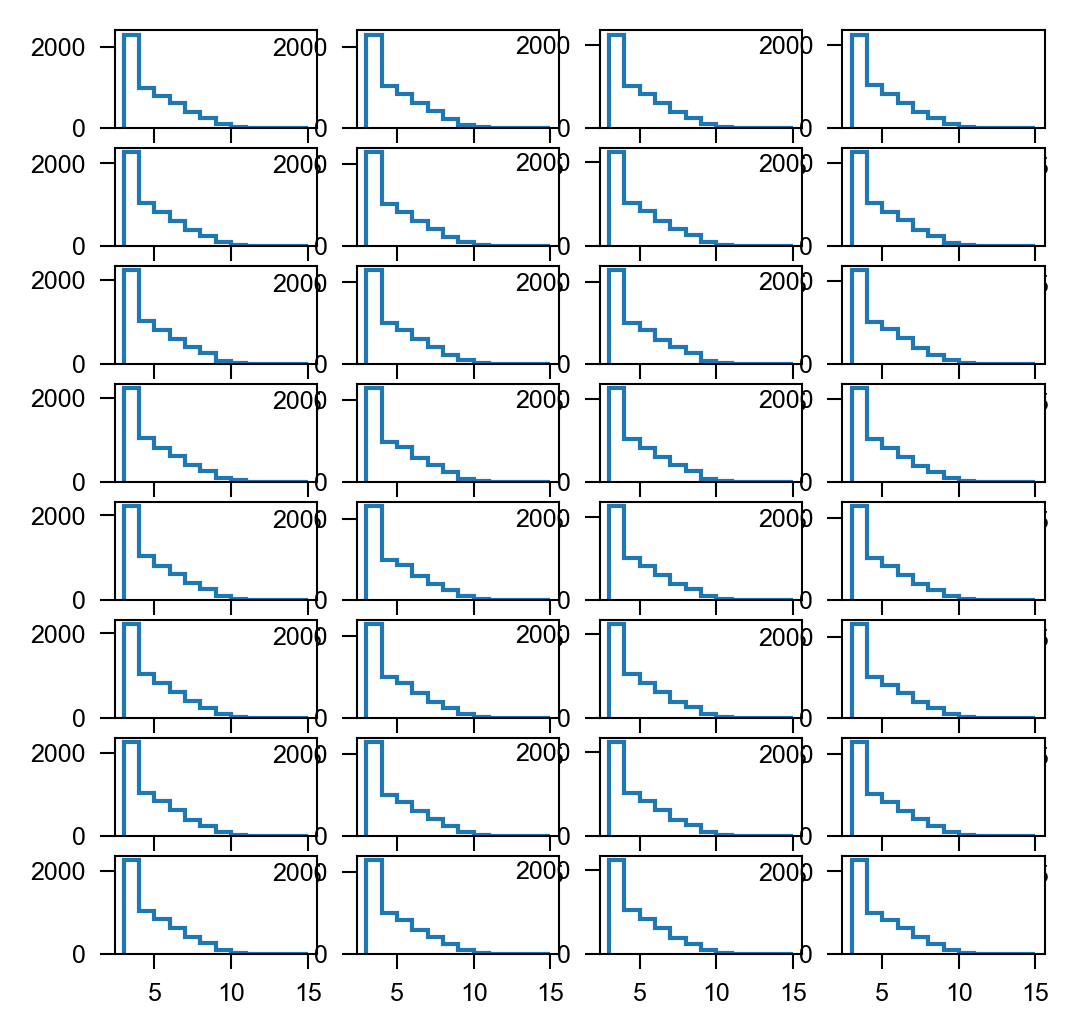

In [ ]:
def axm(ch):
    return  ch%8, 3-(ch//8)
def rip_hist(ripples_df_list):
    fig,ax = plt.subplots(8,4,figsize=(4,4))
    for ch,rip_df in enumerate(ripples_df_list):
        x,y = np.histogram(rip_df['ripple_sd_max'],bins=np.arange(3,16))
        ax[axm(ch)].stairs(x,y)

rip_hist(ripples_df_list)

In [ ]:
nperseg = int(0.05 * downsampled_rate)
noverlap = nperseg // 2
fpass = [2,350]
freqs, spectro_time, spectrogram_data = sci.signal.spectrogram(lfp_disk_array, downsampled_rate, nperseg=nperseg, noverlap=noverlap,axis=0)
spectrogram_data.shape
spectro_fs = spectro_time[1]-spectro_time[0]


In [ ]:
fpass_bool = np.logical_and(freqs>fpass[0] , freqs<fpass[1])
freqs = freqs[fpass_bool]
spectrogram_data = spectrogram_data[fpass_bool,:,:]
spectrogram_data.shape

In [ ]:
spectrogram_data = (spectrogram_data.transpose([2,0,1]) - np.mean(spectrogram_data,axis=2)) / np.std(spectrogram_data,axis=2)

In [ ]:
def fuzzy_time_match(query_time, target_time):
    delta_t = target_time[:,np.newaxis] - query_time
    match_index = np.argmin(abs(delta_t),axis=0)
    match_time = target_time[match_index]
    return match_index,match_time


ripple_trigs = (ripples_dict['ch10']['starts']+ripples_dict['ch10']['max_tic']).values
ripple_trigs_sec = ripple_trigs/downsampled_rate
match_index,match_time = fuzzy_time_match(ripple_trigs_sec,spectro_time)


In [ ]:
spectro_fs = spectro_time[1]-spectro_time[0]
relative_spect_window = np.arange(-.4/spectro_fs,0.4/spectro_fs+spectro_fs)
relative_spect_window_sec = relative_spect_window*spectro_fs
trig_index_mat = (match_index[:,np.newaxis] + relative_spect_window).astype('int')

in_range = np.logical_and( trig_index_mat>=0, trig_index_mat<len(spectro_time))
complete_window = np.min(in_range,axis=1)==1
trig_index_mat = trig_index_mat[complete_window,:]
# trig_index_mat = np.repeat(trig_index_mat[:, :, np.newaxis], spectrogram_ch0.shape[0], axis=2)
trig_index_mat.shape

(3889, 33)

In [ ]:
channel_idx

18

(17, 3889, 33)


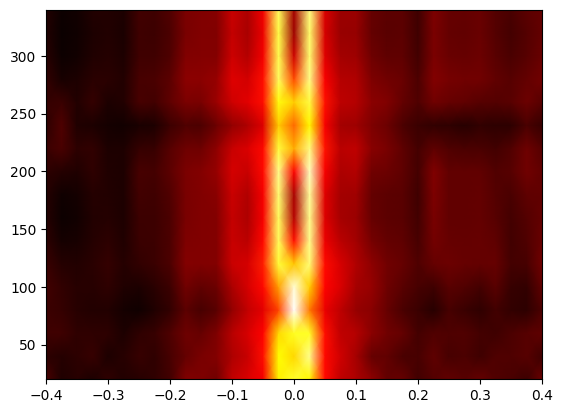

In [ ]:
channel_idx = 18
spectrogram_ch0 = spectrogram_data[:, :, channel_idx].transpose()
spectrogram_ch0.shape

trig_spects = spectrogram_ch0[:,trig_index_mat]
print(trig_spects.shape)
mean_spect = np.mean(trig_spects,axis=1)
fig,ax=plt.subplots()
ax.pcolormesh(relative_spect_window_sec, freqs, mean_spect, cmap='hot',shading='gouraud')

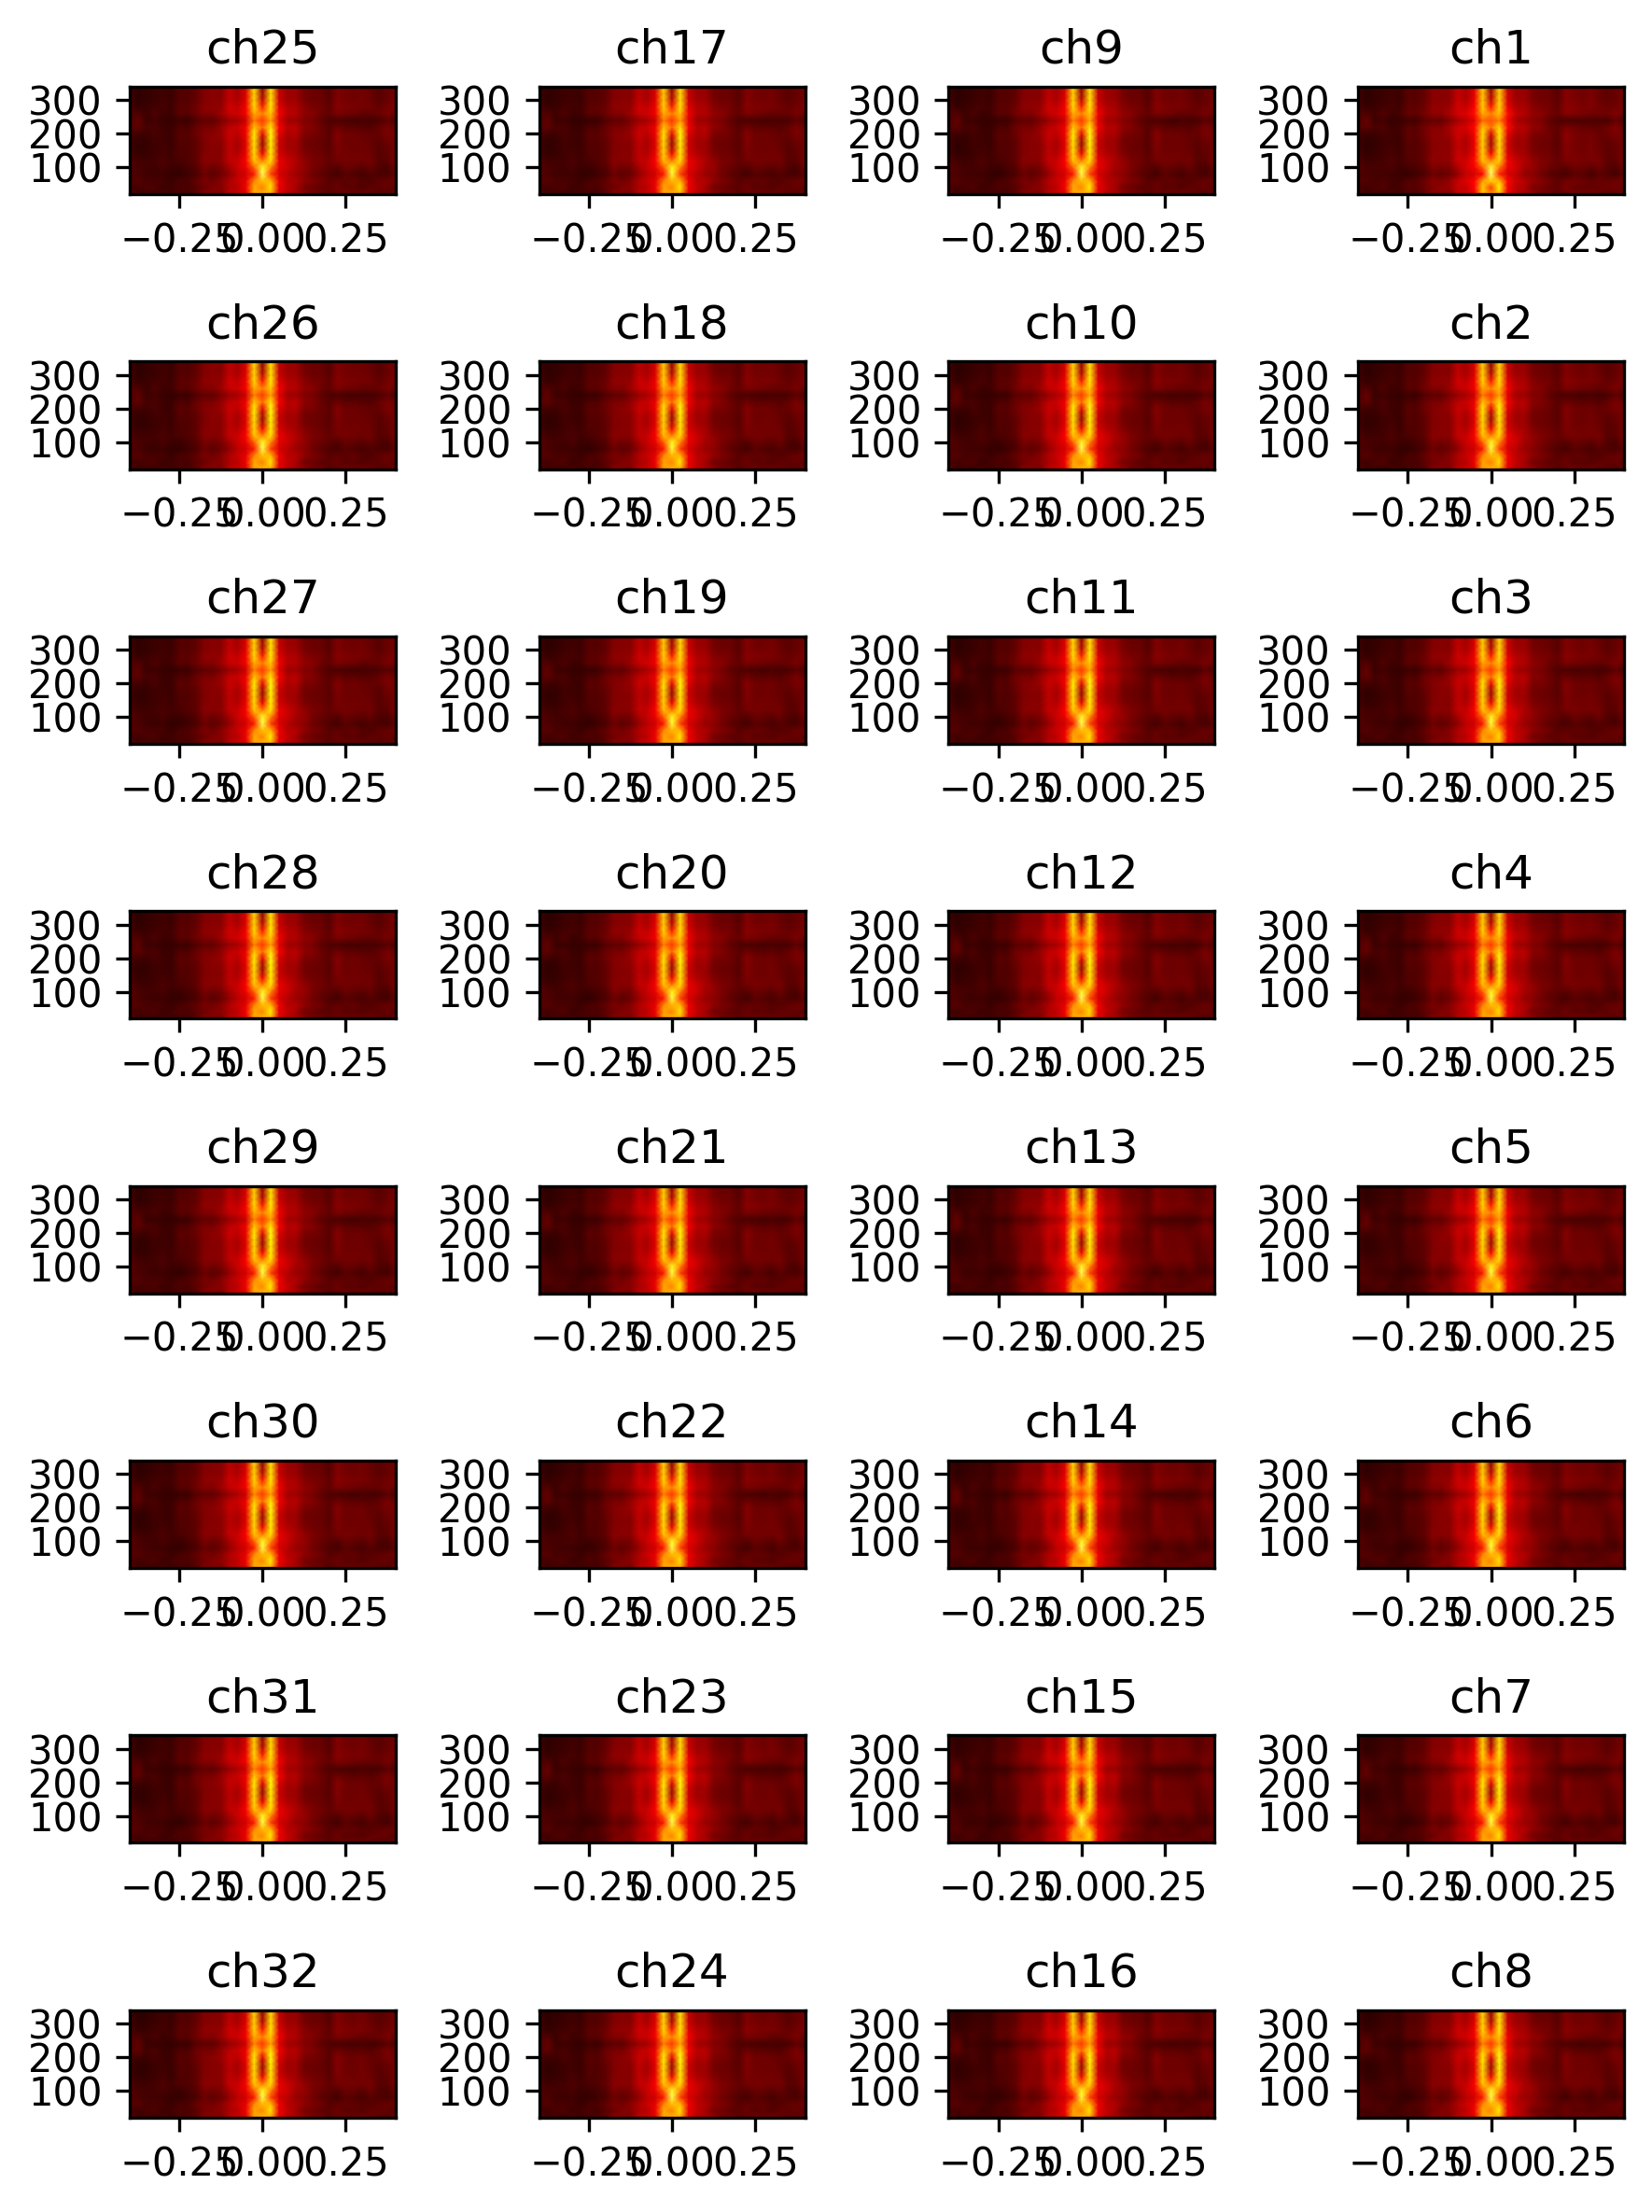

In [ ]:


fig,ax =plt.subplots(8,4,figsize=(6,8),dpi=300)
for ch in range(num_channels):
    i = ch%8
    j = 3-( ch // 8 )
    ax[i,j].set_title(f'ch{ch+1}')
    spectrogram_ch = spectrogram_data[:, :, ch].transpose()
    trig_spects = spectrogram_ch[:,trig_index_mat]
    mean_spect = np.mean(trig_spects,axis=1)
    ax[i,j].pcolormesh(relative_spect_window_sec, freqs, mean_spect, cmap='hot',shading='gouraud',vmin=0,vmax=4)
plt.tight_layout()